$\def \R {\mathbb{R}}$
$\def \cM {\mathcal{M}}$
# Piecewise linear functions on triangulations

As a toy example,
let us consider the univariate transport equation

$$
\partial_t u(x,t)+y \partial_x u(x,t)=0, \quad x\in\R, \; t\geq 0,
$$

with initial value $u_0(x)=\chi_{]-\infty,0]}$, and parameter $y\in [0,1]$. We consider the parametrized family of 
solutions at time $t=1$ restricted to $x\in [0,1]$, that is

$$
\cM = \{ \chi_{[0,y]}\; : \; y\in [0,1]\}.
$$

Here, we choose to work in the Hilbert space $V=L^2([0,1])$ which contains such discontinuous functions.
Due to the presence of discontinuities, it can easily be seen that if 
$V_n$ is the Fourier space generated by the functions $\phi_k$ in eq. (2.5) in the paper, one has the approximation rate

$$
\sup_{u\in\cM} \|u-P_{V_n}u\| \sim n^{-1/2}.
$$

On the other hand, a reduced basis space is of the form

$$
V_n = \mathrm{{span}}\{ \chi_{[0,y_i]} \; : \, i=1,\ldots, n \}.
$$

for some points $y_1,\dots,y_n\in [0,1]$, and therefore a space of piecewise constant functions on the intervals $[y_i,y_{i+1}]$,
assuming that these points have been increasingly ordered.
By taking a $y$ to be the midpoint of the largest of such intervals, that has length larger than $n^{-1}$, it is easily checked that

$$
\|\chi_{[0,y]}-P_{V_n}\chi_{[0,y]}\| \geq  \frac 1 2 n^{-1/2},
$$

and therefore the approximation rate is not better than with the Fourier space. More generally it can be checked than the Kolmogorov
$n$-width of $\cM$ in $V$ decays like $n^{-1/2}$, that is, any linear approximation method cannot have a better rate.



In [36]:
import numpy as np
import scipy as sp
import math
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

### Now we are going to set up a full dictionary of local integration points


In [37]:
np.random.seed(5)
n = 50

sin_vecs = []
for i in range(1,n+1):
    sin_vecs.append(pat.FuncVector(params=[[i]], coeffs=[[math.sqrt(2.0)]], funcs=['L2UISin']))
Vn_sin = pat.Basis(sin_vecs, is_orthonormal=True)

rand_red_vecs = []
rand_points = np.sort(np.random.random(n))[::-1]
for i in range(n):
    rand_red_vecs.append(pat.FuncVector(params=[[rand_points[i]]], coeffs=[[1.0]], funcs=['L2UIHeaviside']))
Vn_red = pat.Basis(rand_red_vecs)
Vn_red_o = Vn_red.orthonormalise()

### Now examine the convergence of projections against a "snapshot" reduced basis and a sinusoidal basis

The idea being that we are examining the balance of both $\mu(V_n, W_m)$ and $\varepsilon$ with the two choices of approximation space

In [38]:
num_sol = 10

solns = []
rand_points = np.random.random(n)
#rand_points = np.linspace(0.0, 1.0, n, endpoint=False) + 0.5 / float(n)
for i in range(num_sol):
    solns.append(pat.FuncVector(params=[[rand_points[i]]], coeffs=[[1.0]], funcs=['L2UIHeaviside']))

dist_sin = np.zeros((num_sol, n))
dist_red = np.zeros((num_sol, n))

for i, v in enumerate(solns):
    for j in range(1,n):
        P_v_sin = Vn_sin.subspace(slice(0,j)).project(v)
        P_v_red = Vn_red.subspace(slice(0,j)).project(v)
        
        dist_sin[i, j] = (v - P_v_sin).norm()
        dist_red[i, j] = (v - P_v_red).norm()

### Now we compare the OMP algorithm against both...  For now we do it here with n=20

In [39]:
m = 100

eps = 1e-2
N = int(1e4)

print('Construct dictionary of local averages...')
D = []
for i in range(N):
    D.append(pat.FuncVector(params=[[( float(i)*(1.0-eps)/float(N-1),( float(i)*(1.0-eps)/float(N-1) + eps ))]], coeffs=[[1.0]], funcs=['L2UIAvg']))

print('Worst-case greedy basis construction...')
n=20
wcbc = pat.WorstCaseOMP(D, Vn_sin.subspace(slice(0,n)), Wm=pat.Basis(), verbose=True)
Wm_wc_sin = wcbc.construct_to_m(m)
Wm_wc_sin_o = Wm_wc_sin.orthonormalise()

wcbc = pat.WorstCaseOMP(D, Vn_red_o.subspace(slice(0,n)), Wm=pat.Basis(), verbose=True)
Wm_wc_red = wcbc.construct_to_m(m)
Wm_wc_red_o = Wm_wc_red.orthonormalise()

bs_wc_sin = np.zeros(m)
bs_wc_red = np.zeros(m)

# For efficiency it makes sense to compute the basis pair and the associated
# cross-gramian only once, then sub sample it as we grow m...
BP_wc_sin_l = pat.BasisPair(Wm_wc_sin_o, Vn_sin.subspace(slice(0,20)))
BP_wc_red_l = pat.BasisPair(Wm_wc_red_o, Vn_red_o.subspace(slice(0,20)))

for i in range(n, m):
    BP_wc_sin =  BP_wc_sin_l.subspace(Wm_indices=slice(0,i))
    BP_wc_red =  BP_wc_red_l.subspace(Wm_indices=slice(0,i))
    
    bs_wc_sin[i] = BP_wc_sin.beta()
    bs_wc_red[i] = BP_wc_red.beta()

Construct dictionary of local averages...
Worst-case greedy basis construction...
i 	 || P_Vn (w - P_Wm w) ||
1 : 	 5252 	 0.013942032028203826
2 : 	 5669 	 0.019945765354894014
3 : 	 7748 	 0.023565900807756425
4 : 	 6750 	 0.023250936481107827
5 : 	 3324 	 0.02312886190846344
6 : 	 8747 	 0.024779422271362147
7 : 	 4225 	 0.0283120922712169
8 : 	 1888 	 0.03163095461951512
9 : 	 9591 	 0.027537865681001326
10 : 	 3801 	 0.026716892889430528
11 : 	 2428 	 0.03167367223217655
12 : 	 2835 	 0.02106814252871074
13 : 	 6150 	 0.030731012791835776
14 : 	 344 	 0.03598499809440482
15 : 	 7227 	 0.03209707738420737
16 : 	 8227 	 0.03353914555319093
17 : 	 1053 	 0.03659665691896643
18 : 	 1422 	 0.032412720300823254
19 : 	 9180 	 0.04635566138941547
20 : 	 4666 	 0.04341068355200636
21 : 	 743 	 0.04505163911960557
22 : 	 6433 	 0.03924476305482455
23 : 	 2207 	 0.038925762067953465
24 : 	 8591 	 0.02916914804312673
25 : 	 7515 	 0.03303791605446655
26 : 	 5884 	 0.028829466303117203
27 : 	 

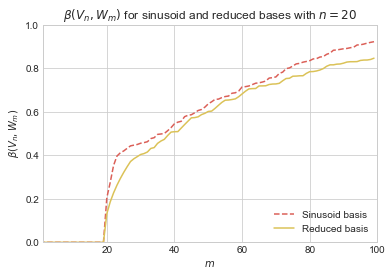

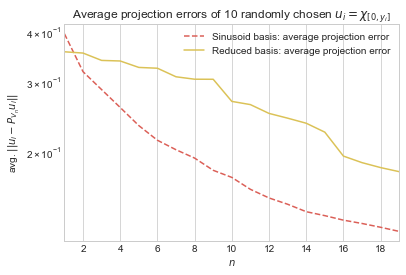

In [47]:
sns.set_style('whitegrid')
line_style = ['-', '--', ':', '-', '-.']

sns.set_palette("hls", 8)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ for sinusoid and reduced bases with $n=20$')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')
    
plt.plot(range(m), bs_wc_sin, '--', label=r'Sinusoid basis')
plt.plot(range(m), bs_wc_red, label=r'Reduced basis')
ax.set(xlim=[1,m], ylim=[0,1], xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$')
ax.legend(loc=4)
plt.savefig('SinVsRedBeta_hyperbolic.pdf')
plt.show()  

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1, title=r'Average projection errors of 10 randomly chosen $u_i = \chi_{{[0,y_i]}}$')

cp = sns.color_palette("hls", 8)
#plt.semilogy(range(1,n), dist_sin[0, 1:], ':', color=cp[0], linewidth=1, label=r'Sinusois basis: proj error single vec')
#for i, v in enumerate(soln_col[1:]):
#    plt.semilogy(range(1,n), dist_sin[i, 1:], ':', color=cp[0], linewidth=1)
plt.semilogy(range(1,n), dist_sin[:,1:n].mean(axis=0), '--', color=cp[0], label=r'Sinusoid basis: average projection error')
    
#plt.semilogy(range(1,n), dist_red[0, 1:], ':', color=cp[1], linewidth=1, label=r'Reduced basis: proj error single vec')
#for i, v in enumerate(soln_col[1:]):
#    plt.semilogy(range(1,n), dist_red[i, 1:], ':', color=cp[1], linewidth=1)
plt.semilogy(range(1,n), dist_red[:,1:n].mean(axis=0), color=cp[1], label=r'Reduced basis: average projection error')
ax.set(xlim=[1,n-1], xlabel=r'$n$', ylabel=r'avg. $||u_i - P_{V_n} u_i ||$')
ax.legend(loc=1)
plt.savefig('SinVsRedProjErr_hyperbolic.pdf')
plt.show()  